### Import necessary Libraries

In [53]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import *
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import LearningCurveDisplay, learning_curve

### Load and save model

In [54]:
import pickle
# Save model
def save_model(file_name, model):
    with open('/kaggle/working/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('/kaggle/working/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

### Load data

In [55]:
df = pd.read_csv('/kaggle/input/balance-data/balanced.csv')

### Split train and test set

In [56]:
X = df.iloc[:,:-1].to_numpy()
Y = df.iloc[:,-1].to_numpy()

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))
print(X_train.shape,X_test.shape)

(8224, 37) (2056, 37)


#### Plot learning curve function

In [58]:
def plot_learning_curve(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train, y=Y_train,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        n_jobs=-1)
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

In [59]:
from sklearn.model_selection import GridSearchCV

### RF gird search

In [60]:
RF_clf = RandomForestClassifier()

In [61]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_leaf_nodes': [None, 1000, 10000]  
}

In [62]:
grid_search = GridSearchCV(RF_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [None, 1000, 10000],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [63]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'max_leaf_nodes': 1000, 'n_estimators': 200}
0.8712306702460453


### SVM grid search

In [64]:
SVM_clf = make_pipeline(
    StandardScaler(),
    PCA(n_components=20),
    SVC()
)

In [65]:
param_grid2 = {
    'svc__C': [1, 10, 18, 20], 
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma': ['scale', 'auto']
}

In [66]:
grid_search2 = GridSearchCV(SVM_clf, param_grid2, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=20)),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 10, 18, 20],
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [67]:
best_params2 = grid_search2.best_params_
best_score2 = grid_search2.best_score_

print(best_params2)
print(best_score2)

{'svc__C': 18, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
0.6856773826163483


### Train with the best param

In [68]:
RF_clf = RandomForestClassifier(max_leaf_nodes = 1000, n_estimators = 200)

In [69]:
RF_clf.fit(X_train, Y_train)
save_model('RF.pkl', SVM_clf)

In [71]:
RF_predictions = RF_clf.predict(X_test)

In [72]:
print(classification_report(Y_test, RF_predictions))

              precision    recall  f1-score   support

      Benign       0.82      0.86      0.84       272
  Bruteforce       0.73      0.86      0.79       239
        DDos       0.99      0.99      0.99       258
         Dos       1.00      0.99      1.00       253
       Mirai       1.00      0.99      0.99       254
       Recon       0.86      0.70      0.77       247
    Spoofing       0.90      0.80      0.84       259
   Web-based       0.77      0.84      0.80       274

    accuracy                           0.88      2056
   macro avg       0.88      0.88      0.88      2056
weighted avg       0.88      0.88      0.88      2056



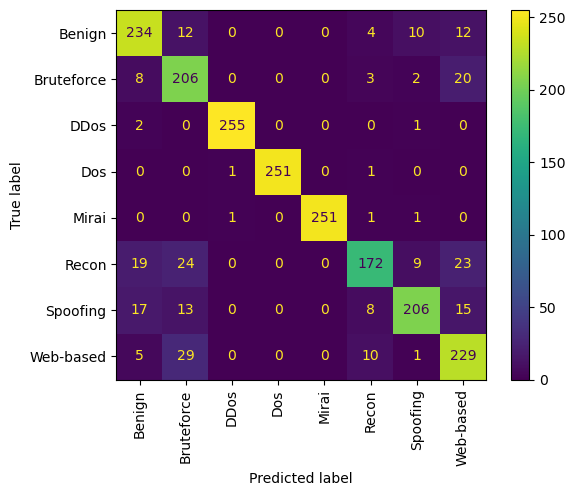

In [75]:
RF_cm = confusion_matrix(Y_test, RF_predictions, labels=RF_clf.classes_)
RF_disp = ConfusionMatrixDisplay(confusion_matrix=RF_cm, display_labels=RF_clf.classes_)
RF_disp.plot(xticks_rotation = "vertical")
plt.show()

In [76]:
SVM_clf = make_pipeline(StandardScaler(),PCA(n_components=20), SVC(C=18,gamma='auto'))

In [77]:
SVM_clf.fit(X_train, Y_train)
save_model('SVM.pkl', SVM_clf)

In [78]:
SVM_pred = SVM_clf.predict(X_test)

In [79]:
print(classification_report(Y_test, SVM_pred))

              precision    recall  f1-score   support

      Benign       0.67      0.65      0.66       272
  Bruteforce       0.50      0.61      0.55       239
        DDos       0.84      0.60      0.70       258
         Dos       0.69      0.87      0.77       253
       Mirai       1.00      0.99      0.99       254
       Recon       0.82      0.51      0.63       247
    Spoofing       0.74      0.54      0.62       259
   Web-based       0.49      0.72      0.58       274

    accuracy                           0.69      2056
   macro avg       0.72      0.69      0.69      2056
weighted avg       0.72      0.69      0.69      2056



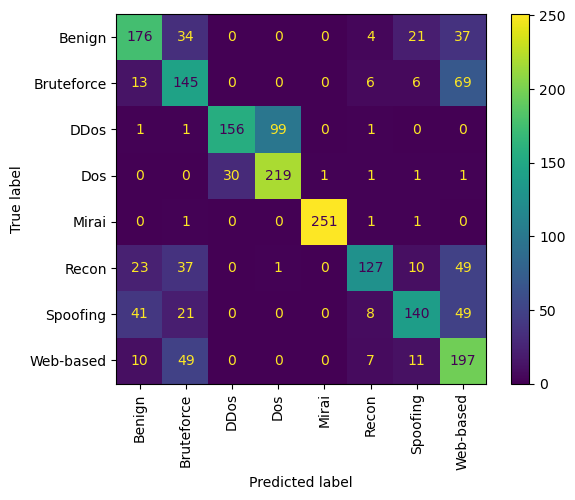

In [80]:
SVM_cm = confusion_matrix(Y_test, SVM_pred, labels=SVM_clf.classes_)
SVM_disp = ConfusionMatrixDisplay(confusion_matrix=SVM_cm, display_labels=SVM_clf.classes_)
SVM_disp.plot(xticks_rotation = "vertical")
plt.show()

In [81]:
ADAboost_clf = make_pipeline(StandardScaler(),PCA(n_components=25), AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=17),n_estimators=50, learning_rate=1.9,random_state=0))

In [85]:
ADAboost_clf.fit(X_train, Y_train)
save_model('ADA.pkl', SVM_clf)

In [86]:
ADA_pred = ADAboost_clf.predict(X_test)

In [87]:
print(classification_report(Y_test, ADA_pred))

              precision    recall  f1-score   support

      Benign       0.63      0.59      0.61       272
  Bruteforce       0.46      0.52      0.49       239
        DDos       0.92      0.86      0.89       258
         Dos       0.87      0.91      0.89       253
       Mirai       1.00      0.99      0.99       254
       Recon       0.58      0.54      0.56       247
    Spoofing       0.66      0.61      0.63       259
   Web-based       0.54      0.59      0.56       274

    accuracy                           0.70      2056
   macro avg       0.71      0.70      0.70      2056
weighted avg       0.71      0.70      0.70      2056



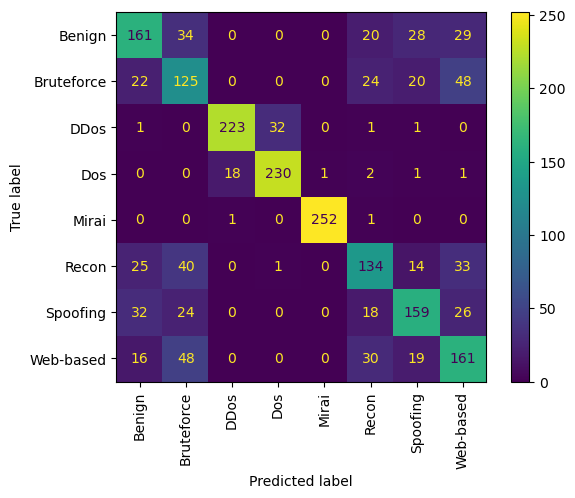

In [88]:
ADA_cm = confusion_matrix(Y_test, ADA_pred, labels=ADAboost_clf.classes_)
ADA_disp = ConfusionMatrixDisplay(confusion_matrix=ADA_cm, display_labels=ADAboost_clf.classes_)
ADA_disp.plot(xticks_rotation = "vertical")
plt.show()